/tmp/ipykernel_1067482/1636428105.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



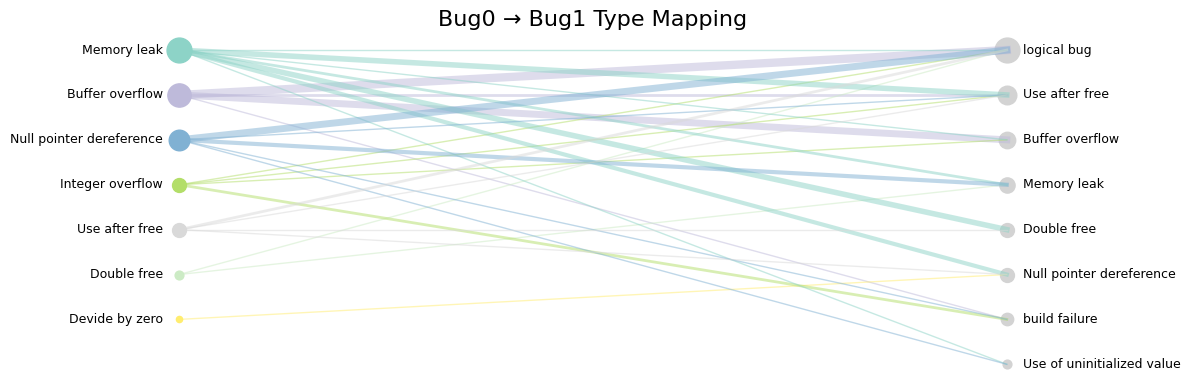

Memory leak -> logical bug: 1
Memory leak -> Use after free: 4
Memory leak -> Buffer overflow: 1
Memory leak -> Memory leak: 2
Memory leak -> Double free: 4
Memory leak -> Null pointer dereference: 3
Memory leak -> Use of uninitialized value: 1
Buffer overflow -> logical bug: 6
Buffer overflow -> Use after free: 2
Buffer overflow -> Buffer overflow: 5
Buffer overflow -> build failure: 1
Null pointer dereference -> logical bug: 5
Null pointer dereference -> Use after free: 1
Null pointer dereference -> Memory leak: 3
Null pointer dereference -> build failure: 1
Null pointer dereference -> Use of uninitialized value: 1
Integer overflow -> logical bug: 1
Integer overflow -> Use after free: 1
Integer overflow -> Buffer overflow: 1
Integer overflow -> build failure: 2
Use after free -> logical bug: 2
Use after free -> Use after free: 1
Use after free -> Double free: 1
Use after free -> Null pointer dereference: 1
Double free -> logical bug: 1
Double free -> Memory leak: 1
Devide by zero -> 

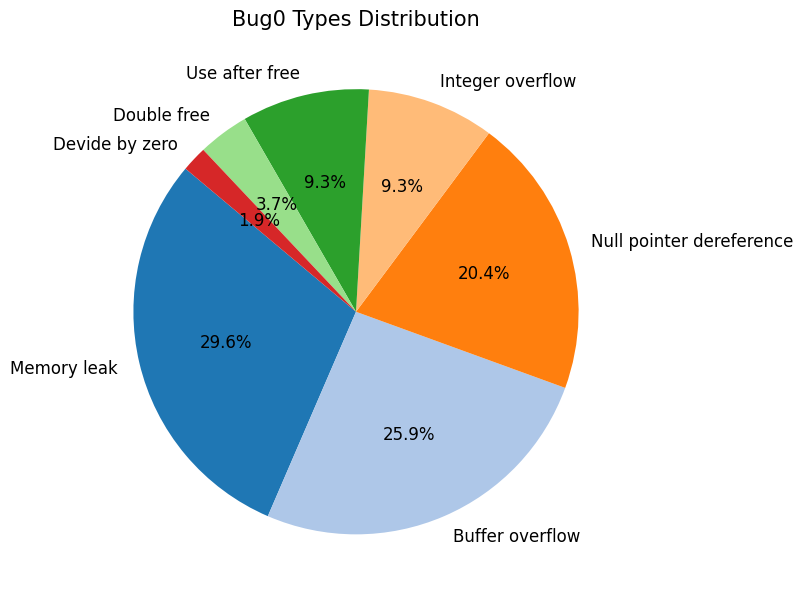

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_map():
    csv_path = '../memory_related_chains_all_source.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)
    
    edge_counts = (
        df
        .groupby(['bug0_types', 'bug1_types'])
        .size()
        .reset_index(name='count')
    )

    bug0_counts = df['bug0_types'].value_counts()
    bug1_counts = df['bug1_types'].value_counts()

    bug0_list = list(bug0_counts.index)
    bug1_list = list(bug1_counts.index)

    pos0 = {bug: (0, i) for i, bug in enumerate(bug0_list)}
    pos1 = {bug: (1, i) for i, bug in enumerate(bug1_list)}
        
    cmap = cm.get_cmap('Set3', len(bug0_list))  # or 'Dark2', 'tab10', etc.
    colors = {bug: cmap(i) for i, bug in enumerate(bug0_list)}

    plt.figure(figsize=(12, max(len(bug0_list), len(bug1_list)) * 0.5))
    ax = plt.gca()

    for _, row in edge_counts.iterrows():
        bug0 = row['bug0_types']
        bug1 = row['bug1_types']
        x0, y0 = pos0[bug0]
        x1, y1 = pos1[bug1]
        ax.plot([x0, x1], [y0, y1],
                linewidth=row['count'],
                alpha=0.5,
                color=colors[bug0])

    for bug, cnt in bug0_counts.items():
        x, y = pos0[bug]
        ax.scatter(x, y, s=cnt * 20, color=colors[bug])

    for bug, cnt in bug1_counts.items():
        x, y = pos1[bug]
        ax.scatter(x, y, s=cnt * 20, color='lightgray')

    for bug in bug0_list:
        x, y = pos0[bug]
        ax.text(x - 0.02, y, bug, ha='right', va='center', fontsize=9)

    for bug in bug1_list:
        x, y = pos1[bug]
        ax.text(x + 0.02, y, bug, ha='left', va='center', fontsize=9)

    ax.invert_yaxis()
    ax.axis('off')
    plt.title('Bug0 → Bug1 Type Mapping', fontsize=16)
    plt.tight_layout()
    plt.show()

    for bug0 in bug0_list:
        for bug1 in bug1_list:
            count = edge_counts.loc[
                (edge_counts['bug0_types'] == bug0) & 
                (edge_counts['bug1_types'] == bug1), 'count'
            ]
            if not count.empty:
                print(f"{bug0} -> {bug1}: {count.values[0]}")

generate_map()

def calculate_portion():
    csv_path = '../memory_related_chains_all_source.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)
    
    bug0_counts = df['bug0_types'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(
        bug0_counts,
        labels=bug0_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.tab20.colors,
        textprops={'fontsize': 12},
    )

    plt.title('Bug0 Types Distribution', fontsize=15)
    plt.tight_layout()
    plt.show()

calculate_portion()

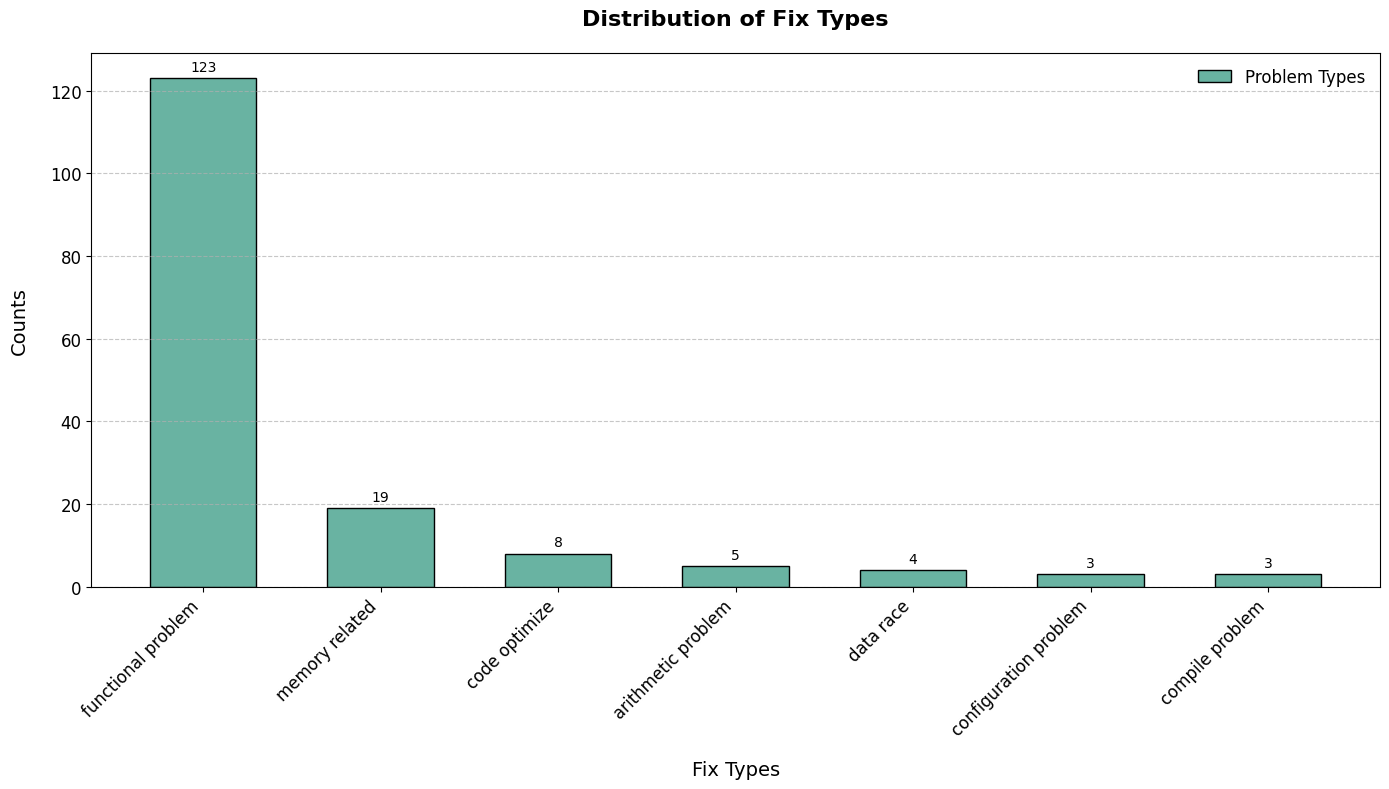

functional problem: 74.55%
memory related: 11.52%
code optimize: 4.85%
arithmetic problem: 3.03%
data race: 2.42%
configuration problem: 1.82%
compile problem: 1.82%


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read your CSV
df = pd.read_csv('regression_chains_samples.csv')
df['bug0_types'] = df['bug0_types'].astype(str)

# Prepare counts
bug0_counts = df['bug0_types'].value_counts()

# Draw a better styled plot
plt.figure(figsize=(14, 8))
bars = plt.bar(
    bug0_counts.index,
    bug0_counts.values,
    color="#69b3a2",
    edgecolor="black",
    width=0.6,
)

# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Polish the appearance
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Fix Types', fontsize=14, labelpad=15)
plt.ylabel('Counts', fontsize=14, labelpad=15)
plt.title('Distribution of Fix Types', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove the frame around the legend
plt.legend(['Problem Types'], frameon=False, fontsize=12)

plt.tight_layout()
plt.show()

# Print percentage
total = sum(bug0_counts)
for bug, count in bug0_counts.items():
    percentage = (count / total) * 100
    print(f"{bug}: {percentage:.2f}%")


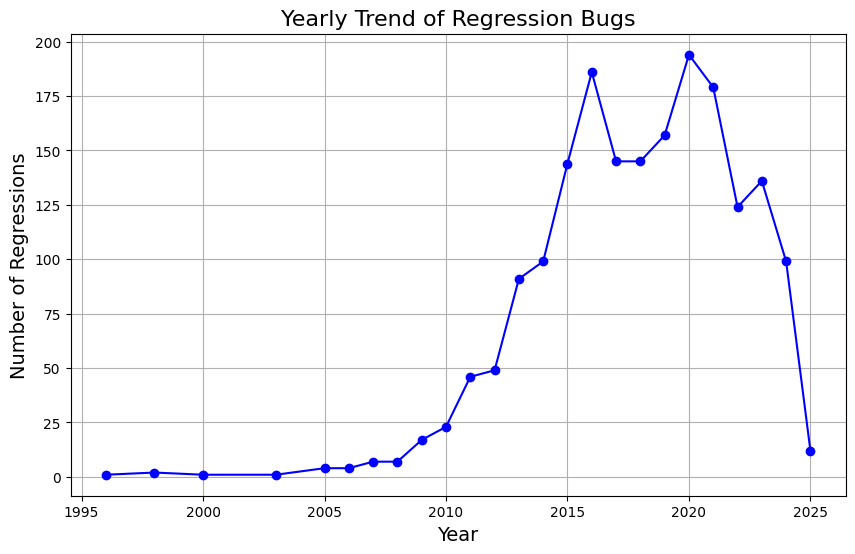

In [6]:
"""
Analyse trends of regression bugs
"""
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('regression_information.csv')
df['BIC_time'] = pd.to_datetime(df['BIC_time'], errors='coerce')

df['year'] = df['BIC_time'].dt.year
df = df.dropna(subset=['year'])
yearly_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-', color='b')
plt.title('Yearly Trend of Regression Bugs', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Regressions', fontsize=14)
plt.grid()
plt.show()

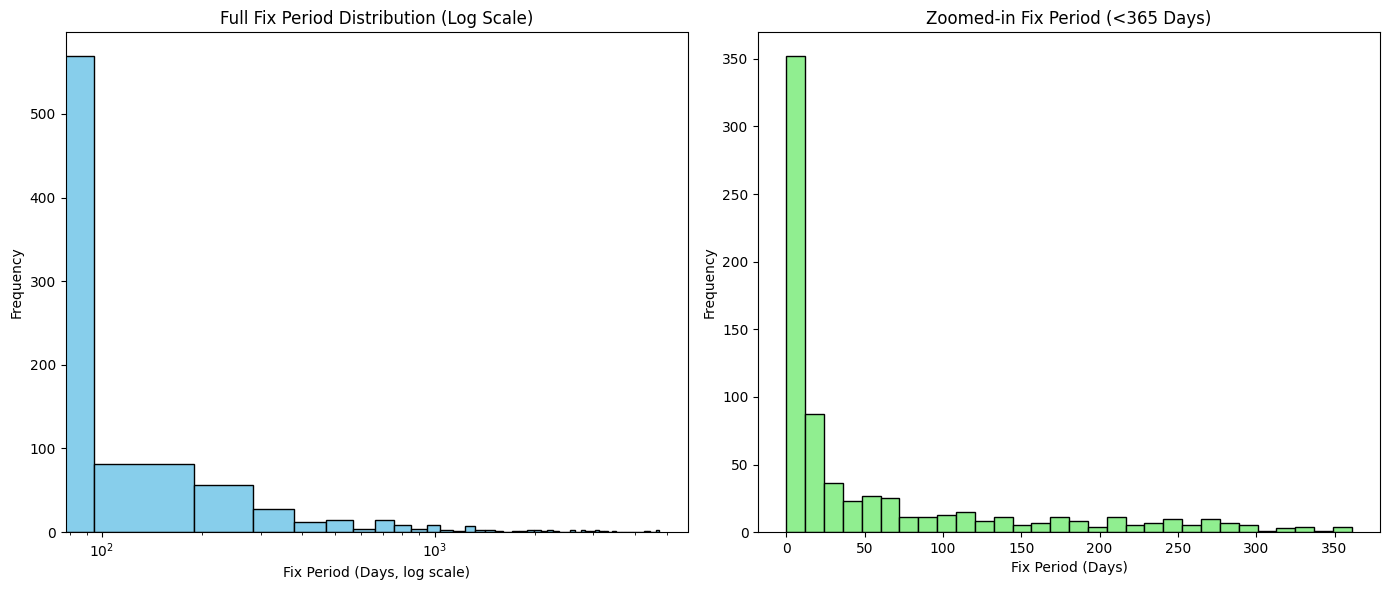

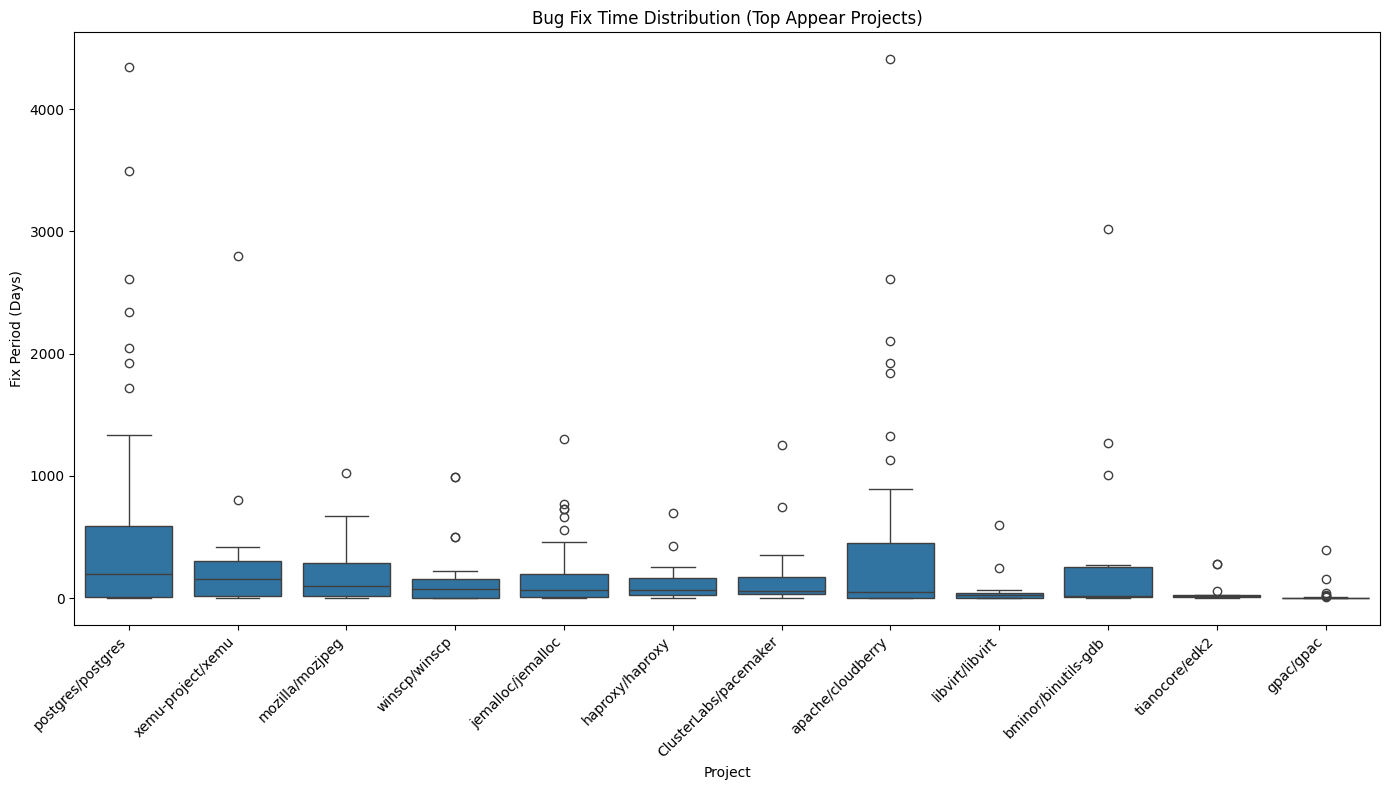

In [14]:
"""
Analyse regression chains
"""
df = pd.read_csv('regression_chains_information.csv')  

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['fix_period'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xscale('log')  # Log scale because of wide range
axes[0].set_title('Full Fix Period Distribution (Log Scale)')
axes[0].set_xlabel('Fix Period (Days, log scale)')
axes[0].set_ylabel('Frequency')

zoom_data = df[df['fix_period'] < 365]['fix_period']
axes[1].hist(zoom_data, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Zoomed-in Fix Period (<365 Days)')
axes[1].set_xlabel('Fix Period (Days)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

import seaborn as sns

# Count how many times each project appears
project_counts = df['repo'].value_counts()

# Keep only projects with more than 10 regression chains, this number can be change later
top_projects = project_counts[project_counts >= 15].index

# Filter the DataFrame
filtered_df = df[df['repo'].isin(top_projects)]

# Plot with filtered data
plt.figure(figsize=(14, 8))
order = filtered_df.groupby('repo')['fix_period'].median().sort_values(ascending=False).index
sns.boxplot(data=filtered_df, x='repo', y='fix_period', order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Bug Fix Time Distribution (Top Appear Projects)')
plt.xlabel('Project')
plt.ylabel('Fix Period (Days)')
plt.tight_layout()
plt.show()


/tmp/ipykernel_1067482/467383711.py:8: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



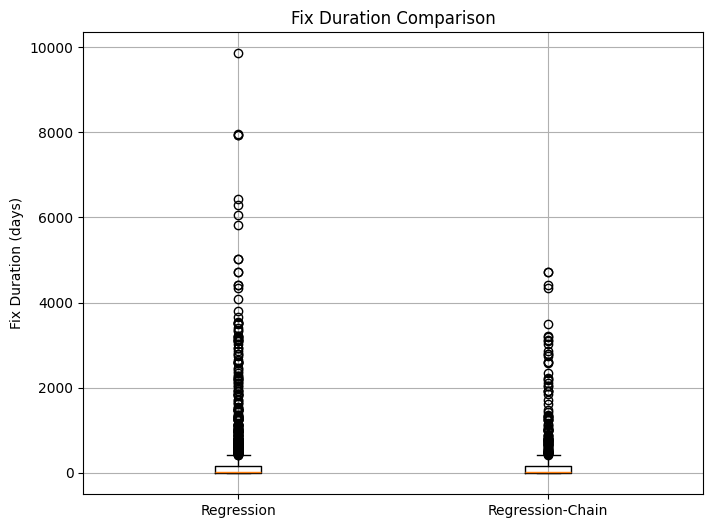

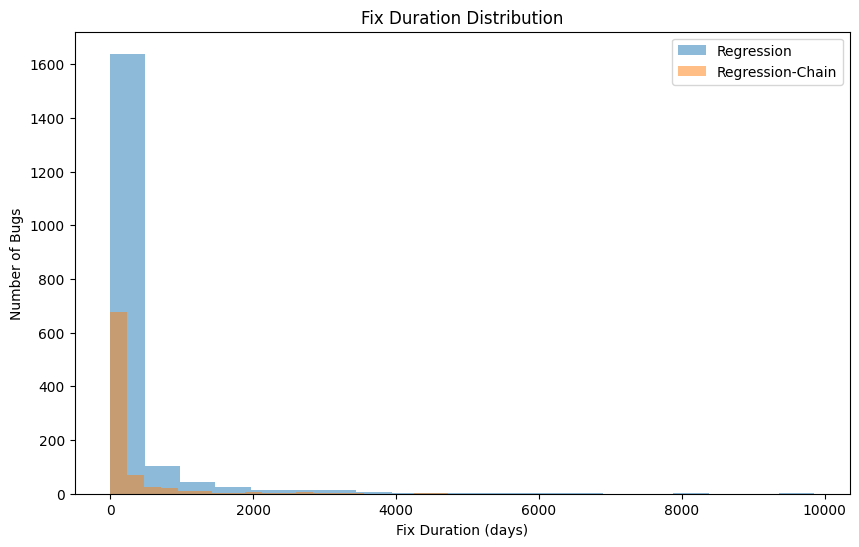

T-test: t = 1.69, p = 0.0916


In [34]:
"""
Compare the bug fix time of regressions and regression chains
"""
reg = pd.read_csv('regression_information.csv')
regchain = pd.read_csv('regression_chains_information.csv')  

plt.figure(figsize=(8, 6))
plt.boxplot([reg['fix_period'], regchain['fix_period']], labels=['Regression', 'Regression-Chain'])
plt.ylabel('Fix Duration (days)')
plt.title('Fix Duration Comparison')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(reg['fix_period'], bins=20, alpha=0.5, label='Regression')
plt.hist(regchain['fix_period'], bins=20, alpha=0.5, label='Regression-Chain')
plt.xlabel('Fix Duration (days)')
plt.ylabel('Number of Bugs')
plt.legend()
plt.title('Fix Duration Distribution')
plt.show()

from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(reg['fix_period'], regchain['fix_period'], equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")
